In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
is_mlp = True

motions = ('LR', 'RL', 'CW', 'CCW')
persons = ('CJW', 'JSI', 'KB', 'KJY', 'KME', 'PJS')

base_dir = Path().resolve().absolute()
data_dir = base_dir / 'Data4(500 frame) - (training data) - (Only A-B) - (80 item)'

In [3]:
class2idx = {x: i for i, x in enumerate(motions)}
idx2class = {v: k for k, v in class2idx.items()}

dfs = []
for motion in motions:
    for person in persons:
        for x in data_dir.glob(f'*.{motion}/{person}/A-B/*.csv'):
            df = pd.read_csv(x, header=None).transpose()
            # df['person'] = person
            df['motion'] = motion
            dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df['motion'].replace(class2idx, inplace=True)

In [4]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.01, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.01, stratify=y_trainval)

In [6]:
X_train.shape

(1881, 500)

In [7]:
if is_mlp:
    pca = PCA(25)
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
class ClassifierDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    
    def __len__(self):
        return len(self.data)

In [9]:
train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [10]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.0001

NUM_FEATURES = len(X.columns)
NUM_CLASSES = len(class2idx)

if is_mlp:
    NUM_FEATURES = 25

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [12]:
class MLP(nn.Module):
    def __init__(self, num_feature, num_class):
        super().__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.mish = nn.Mish()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.mish(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.mish(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.mish(x)
        x = self.dropout(x)
        
        x = self.layer_4(x)
        x = self.batchnorm4(x)
        x = self.mish(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        return x

In [13]:
class CNN(nn.Module):
    def __init__(self, num_feature, num_class):
        super().__init__()
        # -> 5@248 -> 5@124
        self.conv1 = nn.Conv1d(1, 5, 5, 2)
        self.norm1 = nn.BatchNorm1d(5)
        self.pool1 = nn.AvgPool1d(2, 2)
        # -> 20@60 -> 20@30
        self.conv2 = nn.Conv1d(5, 20, 5, 2)
        self.norm2 = nn.BatchNorm1d(20)
        self.pool2 = nn.AvgPool1d(2, 2)
        # -> 5@28 -> 5@14
        self.conv3 = nn.Conv1d(20, 5, 3)
        self.norm3 = nn.BatchNorm1d(5)
        self.pool3 = nn.AvgPool1d(2, 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(5 * 14, 128)
        self.fc2 = nn.Linear(128, num_class)
    
    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.pool1(self.relu(self.norm1(self.conv1(x))))
        x = self.pool2(self.relu(self.norm2(self.conv2(x))))
        x = self.pool3(self.relu(self.norm3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [15]:
if is_mlp:
    model = MLP(num_feature=NUM_FEATURES, num_class=NUM_CLASSES)
else:
    model = CNN(num_feature=NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MLP(
  (layer_1): Linear(in_features=25, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=4, bias=True)
  (mish): Mish()
  (dropout): Dropout(p=0.25, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [16]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [17]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [18]:
print("Begin training.")
for e in range(1, EPOCHS+1):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_acc = 0
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.
Epoch 001: | Train Loss: 1.10649 | Val Loss: 0.92104 | Train Acc: 56.458| Val Acc: 73.684
Epoch 002: | Train Loss: 0.80363 | Val Loss: 0.71705 | Train Acc: 75.288| Val Acc: 73.684
Epoch 003: | Train Loss: 0.68696 | Val Loss: 0.63681 | Train Acc: 79.669| Val Acc: 84.211
Epoch 004: | Train Loss: 0.59818 | Val Loss: 0.59474 | Train Acc: 82.585| Val Acc: 84.211
Epoch 005: | Train Loss: 0.53249 | Val Loss: 0.53097 | Train Acc: 85.271| Val Acc: 84.211
Epoch 006: | Train Loss: 0.47637 | Val Loss: 0.51402 | Train Acc: 86.195| Val Acc: 84.211
Epoch 007: | Train Loss: 0.43979 | Val Loss: 0.46373 | Train Acc: 87.381| Val Acc: 84.211
Epoch 008: | Train Loss: 0.39692 | Val Loss: 0.45909 | Train Acc: 89.068| Val Acc: 84.211
Epoch 009: | Train Loss: 0.36591 | Val Loss: 0.42821 | Train Acc: 89.881| Val Acc: 84.211
Epoch 010: | Train Loss: 0.33256 | Val Loss: 0.42107 | Train Acc: 91.042| Val Acc: 89.474
Epoch 011: | Train Loss: 0.30416 | Val Loss: 0.42916 | Train Acc: 92.390| Val Acc: 8

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

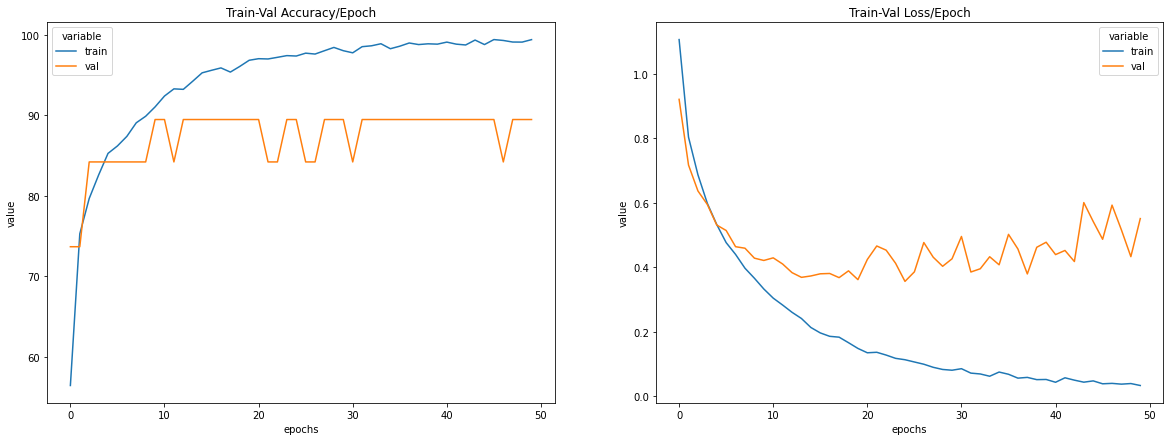

In [19]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [20]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim=1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
print(classification_report(y_test, y_pred_list, digits=4, target_names=motions))

              precision    recall  f1-score   support

          LR     0.8000    0.8000    0.8000         5
          RL     0.8333    1.0000    0.9091         5
          CW     1.0000    0.8000    0.8889         5
         CCW     1.0000    1.0000    1.0000         5

    accuracy                         0.9000        20
   macro avg     0.9083    0.9000    0.8995        20
weighted avg     0.9083    0.9000    0.8995        20



In [21]:
X_test = torch.tensor([[0.5443, 0.1501, 0.2573, 0.3037, 0.2820, 0.6485, 0.5821, 0.6623, 0.4477,
         0.5488, 0.4024, 0.5839, 0.4573, 0.3589, 0.5379, 0.3807, 0.4899, 0.5739,
         0.3629, 0.4590, 0.4574, 0.4820, 0.4135, 0.3357, 0.4409],
        [0.4991, 0.2066, 0.1684, 0.2610, 0.3689, 0.6105, 0.4895, 0.6593, 0.4780,
         0.5871, 0.4615, 0.4859, 0.3186, 0.3344, 0.4756, 0.3493, 0.4605, 0.4670,
         0.3320, 0.3860, 0.4398, 0.4825, 0.4603, 0.4579, 0.4718],
        [0.4722, 0.1531, 0.3449, 0.1444, 0.3251, 0.6171, 0.5892, 0.5833, 0.3064,
         0.6773, 0.3137, 0.6257, 0.4131, 0.3100, 0.5420, 0.3651, 0.4957, 0.5617,
         0.3645, 0.4801, 0.4423, 0.4803, 0.4020, 0.4021, 0.4445],
        [0.6123, 0.2580, 0.2018, 0.3867, 0.1705, 0.5863, 0.5853, 0.5290, 0.3660,
         0.5165, 0.4231, 0.5219, 0.4978, 0.3188, 0.4666, 0.3831, 0.3225, 0.5387,
         0.3801, 0.4548, 0.5025, 0.5328, 0.6123, 0.5288, 0.4796],
        [0.4671, 0.8987, 0.2736, 0.4068, 0.4196, 0.4860, 0.6069, 0.5674, 0.5770,
         0.6051, 0.5092, 0.4967, 0.4903, 0.3874, 0.4401, 0.5010, 0.4075, 0.3873,
         0.3076, 0.4715, 0.4175, 0.4717, 0.4370, 0.4156, 0.4534],
        [0.5609, 0.2029, 0.1331, 0.2525, 0.3308, 0.5926, 0.4195, 0.6161, 0.4709,
         0.5610, 0.4529, 0.4977, 0.3404, 0.3229, 0.4931, 0.3638, 0.4795, 0.4810,
         0.3351, 0.4155, 0.4545, 0.4770, 0.4523, 0.4493, 0.4506],
        [0.5295, 0.0968, 0.4577, 0.2190, 0.1978, 0.6570, 0.7225, 0.4720, 0.2962,
         0.5371, 0.2142, 0.6993, 0.6027, 0.3593, 0.4615, 0.5204, 0.4892, 0.4419,
         0.3289, 0.5131, 0.4363, 0.4425, 0.3712, 0.4010, 0.4697],
        [0.5354, 0.4225, 0.0386, 0.3487, 0.6792, 0.3401, 0.3685, 0.5500, 0.5060,
         0.5823, 0.6146, 0.2895, 0.4901, 0.4310, 0.4253, 0.6336, 0.4546, 0.2521,
         0.3173, 0.4920, 0.4341, 0.4358, 0.3987, 0.4559, 0.4666],
        [0.4239, 0.2383, 0.1145, 0.3773, 0.3389, 0.5900, 0.4569, 0.6021, 0.4590,
         0.6119, 0.3526, 0.5019, 0.3298, 0.3393, 0.4405, 0.3548, 0.4592, 0.4305,
         0.3309, 0.4031, 0.4411, 0.4691, 0.4514, 0.4269, 0.4750],
        [0.5077, 0.3823, 0.0180, 0.4318, 0.5645, 0.3612, 0.4486, 0.4847, 0.5404,
         0.5868, 0.5039, 0.4071, 0.4122, 0.3628, 0.4771, 0.4798, 0.4595, 0.3607,
         0.3249, 0.4273, 0.4382, 0.4449, 0.4413, 0.4713, 0.4757],
        [0.4470, 0.2588, 0.0996, 0.3734, 0.3700, 0.5390, 0.4440, 0.5725, 0.5129,
         0.5684, 0.4131, 0.4517, 0.3585, 0.3537, 0.4343, 0.4047, 0.4677, 0.4092,
         0.3169, 0.4293, 0.4507, 0.4639, 0.4207, 0.4648, 0.4751],
        [0.4572, 0.3820, 0.0546, 0.4718, 0.6418, 0.3869, 0.3847, 0.5725, 0.5539,
         0.5889, 0.5682, 0.3362, 0.3907, 0.3907, 0.4296, 0.5353, 0.4431, 0.2984,
         0.3118, 0.4497, 0.4209, 0.4245, 0.4201, 0.4667, 0.4674],
        [0.4475, 0.3519, 0.0721, 0.4272, 0.6326, 0.3818, 0.4397, 0.5150, 0.4977,
         0.5727, 0.4836, 0.4043, 0.3544, 0.3463, 0.4361, 0.4372, 0.4586, 0.3856,
         0.3184, 0.4014, 0.4500, 0.4555, 0.4481, 0.4496, 0.4795],
        [0.5153, 0.4026, 0.0264, 0.4768, 0.6169, 0.3555, 0.3632, 0.5173, 0.5419,
         0.5490, 0.5485, 0.4131, 0.4380, 0.3641, 0.4668, 0.4926, 0.4761, 0.3625,
         0.3194, 0.4360, 0.4490, 0.4466, 0.4360, 0.4557, 0.4726],
        [0.4880, 0.4782, 0.5367, 0.5680, 0.5163, 0.2965, 0.3687, 0.4766, 0.6361,
         0.7667, 0.3940, 0.1334, 0.7106, 0.0464, 0.9461, 0.0291, 0.4996, 0.1442,
         0.7352, 0.6208, 0.3083, 0.6482, 0.5200, 0.6449, 0.0000],
        [0.4935, 0.5167, 0.5929, 0.6714, 0.6120, 0.2839, 0.5729, 0.2244, 0.6341,
         0.0000, 0.5418, 0.6294, 0.9383, 0.4728, 0.2742, 0.5755, 0.4368, 0.1112,
         0.2553, 0.2710, 0.6688, 0.5928, 0.3789, 0.1551, 0.4769]],
       device='cuda:0')

In [22]:
df_test = pd.concat([pd.read_csv(x, header=None).transpose() for x in base_dir.glob(f'TestData/*.csv')], ignore_index=True)
X_test = df_test.to_numpy()
X_test = pca.transform(X_test)
X_test = scaler.transform(X_test)
X_test = torch.from_numpy(X_test).float()

In [23]:
with torch.no_grad():
    model.eval()
    X_test = X_test.to(device)
    y_test_pred = model(X_test)
    _, y_pred_tags = torch.max(y_test_pred, dim=1)
    y_pred = y_pred_tags.cpu().numpy().squeeze().tolist()

In [24]:
for x in y_pred:
    print(x+1)

2
4
3
1
1
1
3
1
2
2
3
2
1
2
1
1
4
1
1
4
4
2
3
1
4
3
2
1
1
3
1
3
2
1
4
1
4
3
3
1
1
2
1
2
1
2
4
3
4
4
2
2
1
2
2
2
4
2
4
1
2
1
1
2
1
2
1
3
3
2
3
3
2
2
1
2
4
2
1
4
2
4
3
1
1
3
1
4
1
3
3
3
1
3
3
4
3
4
2
4
2
2
3
2
2
3
3
4
3
4
4
3
4
1
4
3
3
3
1
3
